In [105]:
import fsspec
import zarr
import xarray as xr
import random
import matplotlib.pyplot as plt
import numpy as np

# Demo access with xarray and Dask

This section aims at showing how much time is needed to randomly access data from a remote data cube in a non optimal way.

We open a connection to a remote data cube (UC3 sub cube for time series analysis) and access its five variables: avg_rh ignition_points time burned_areas lst_day x evi y

In [106]:
m = fsspec.get_mapper("https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/UC3SubCube_ts.zarr")
g = xr.open_zarr(m)
g

,Array,Chunk
Bytes,20.92 GiB,781.25 kiB
Shape,"(4560, 983, 1253)","(500, 20, 20)"
Count,31501 Tasks,31500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,20.92 GiB,781.25 kiB
Shape,"(4560, 983, 1253)","(500, 20, 20)"
Count,31501 Tasks,31500 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


We then randomly sample 20 locations in the cube over a fixed time range

In [120]:
randlat = list(map(lambda x: random.randrange(g.dims['y']),range(20)))
randlon = list(map(lambda x: random.randrange(g.dims['x']),range(20)))
print(randlat)
print(randlon)

[819, 139, 281, 713, 823, 8, 752, 7, 520, 312, 343, 879, 835, 508, 355, 879, 511, 241, 914, 12]
[1131, 265, 676, 555, 635, 721, 904, 156, 153, 671, 714, 295, 68, 883, 191, 757, 1058, 1052, 535, 184]


In [123]:
lonind = xr.DataArray(randlon,dims = "points")
latind = xr.DataArray(randlat,dims="points")
selection = g.isel(y=latind,x=lonind)

#selection = g.isel(x=randlon, y=randlat).loc[dict(time=slice("2009-01-01", "2016-12-31"))]

In [124]:
selection = selection.compute()

In [125]:
selection

<xarray.Dataset>
Dimensions:          (time: 4560, points: 20)
Coordinates:
  * time             (time) datetime64[ns] 2009-03-06T10:00:00 ... 2021-08-29...
    x                (points) float64 27.91 20.86 24.21 ... 27.27 23.06 20.2
    y                (points) float64 35.63 41.17 40.01 ... 40.34 34.85 42.2
Dimensions without coordinates: points
Data variables:
    avg_rh           (time, points) float32 nan 0.8026 0.651 ... nan 0.6785
    burned_areas     (time, points) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    evi              (time, points) float32 nan 2.345e+07 nan ... nan 4.311e+07
    ignition_points  (time, points) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lst_day          (time, points) float32 nan nan nan nan ... 306.0 nan nan

We use this selection to plot evi.

Text(0.5, 1.0, 'data accessed with xarray')

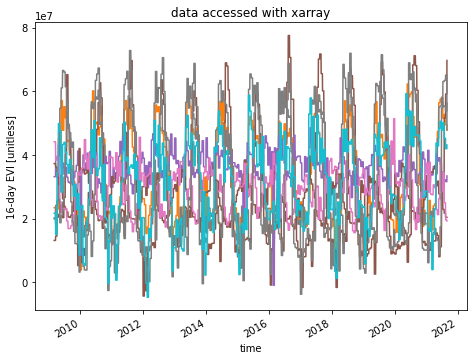

In [127]:
fill_value = 1e32
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
for i in range(selection.dims["points"]):
    y = selection.evi.isel(points=i)
    y.plot.line(ax=ax)

ax.set_title("data accessed with xarray")

# BatchShuffler

BatchShuffleServer gives an example of how to launch a server for the sampler from a Docker containor.

First we need to build the docker:

```bash
sudo docker build -t batchshuffler .
```

Then we launch the server with:
```bash
path_to_cube="https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/UC3SubCube_ts.zarr"
vars_to_include="burned_areas,avg_rh,ignition_points,lst_day,evi"
start_year=2009
end_year=2016
repeats_per_collection=20
batchsize=100
nchunks=10
ip="0.0.0.0"
port=9052
fillvalue="1.0e32"


docker run -p 9052:9052 batchshuffler $path_to_cube -v $vars_to_include -s $start_year -e $end_year -r $repeats_per_collection -b $batchsize -n $nchunks --ip $ip -p $port -f $fillvalue
```

In this case we sample a subset of the UC3 cube for five variables (burned_areas, avg_rh, ignition_points, lst_day, evi) for years 2009 to 2016.
Each batch consits of 100 collections of 20 randomly sampled locations.
10 chunks are held in memory contemporarily.

The server runs at the specified IP address and port within the container. The above instructions are saved in file launch_server.sh, in the github repository /meggart/BatchShufflerServer

```
sh launch_server.sh
```


On Linux, the ip address of the server can be retrieved with:

```bash
sudo ip addr show docker0
```

On Mac, you first get the container id with `docker ps`, then retrieve the Gateway address with `docker inspect`.

Once the server is launched, it can be called with Zarr.zopen()

# Demo with batch shuffler


In [88]:
# m = fsspec.get_mapper("http://macadamia.bgc-jena.mpg.de:9052")
# change the ip address as necessary
m = fsspec.get_mapper("http://127.0.0.1:9052")
g = zarr.open_consolidated(m)

In [89]:
batches = g["batches"]

In [90]:
batches.shape

(100, 5, 2858)

In [91]:
type(batches)

zarr.core.Array

In [99]:
fill_value = 1e32

data = batches[:,:,:]


Text(0.5, 0, 'time since 2009 [days]')

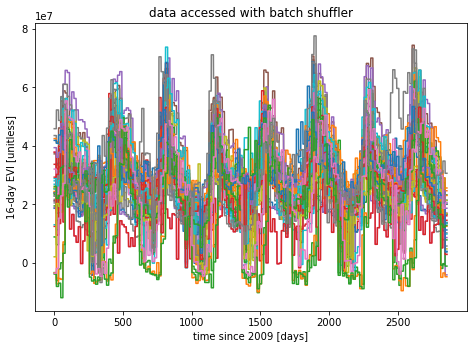

In [100]:

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
evi = data[:,4,:]
for i in range(100):
    y = evi[i,:]
    ax.plot(np.ma.masked_where(y == fill_value, y))

ax.set_title("data accessed with batch shuffler")
ax.set_ylabel("16-day EVI [unitless]")
ax.set_xlabel("time since 2009 [days]")